In [1]:
!pip install --quiet gymnasium matplotlib numpy

In [2]:
!pip install --quiet optuna

In [3]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
import optuna

# PART 1: ENVIRONMENT DEFINITION

In [4]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self, max_timesteps=10):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.battery1_pos = [0, 3]
        self.battery2_pos = [2, 3]
        self.rock1_pos = [2, 0]
        self.rock2_pos = [3, 1]

        self.state = np.zeros((4,4))

        self.state[tuple(self.goal_pos)] = 4
        self.state[tuple(self.battery1_pos)] = 6
        self.state[tuple(self.battery2_pos)] = 6
        self.state[tuple(self.rock1_pos)] = 12
        self.state[tuple(self.rock2_pos)] = 12
        self.state[tuple(self.agent_pos)] = 10

        self.total_rewards = 0

        
    def reset(self, **kwargs):

        self.timestep = 0
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.battery1_pos = [0, 3]
        self.battery2_pos = [2, 3]
        self.rock1_pos = [2, 0]
        self.rock2_pos = [3, 1]

        self.state = np.zeros((4,4))

        self.state[tuple(self.goal_pos)] = 4
        self.state[tuple(self.battery1_pos)] = 6
        self.state[tuple(self.battery2_pos)] = 6
        self.state[tuple(self.rock1_pos)] = 12
        self.state[tuple(self.rock2_pos)] = 12
        self.state[tuple(self.agent_pos)] = 10

        observation = self.state.flatten()
        self.total_rewards = 0

        return observation, self.total_rewards
    
    def step(self, action):
        # agent moves down
        if action == 0:
          self.agent_pos[0] += 1

        # agent moves up
        if action == 1:
          self.agent_pos[0] -= 1

        # agent moves right
        if action == 2:
          self.agent_pos[1] += 1

        # agent moves left
        if action == 3:
          self.agent_pos[1] -= 1

        # prevents agent from moving out of board
        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state = np.zeros((4,4))
        self.state[tuple(self.goal_pos)] = 4
        if(self.battery1_pos[0] != 10):
          self.state[tuple(self.battery1_pos)] = 6
        if(self.battery2_pos[0] != 10):
          self.state[tuple(self.battery2_pos)] = 6
        self.state[tuple(self.rock1_pos)] = 12
        self.state[tuple(self.rock2_pos)] = 12
        self.state[tuple(self.agent_pos)] = 10
        observation = self.state.flatten()
        
        reward = 0
        terminated = False
        condition_passed = False
        negative_condition_passed = True

        if np.array_equal(self.agent_pos, self.goal_pos):
          condition_passed = True
          terminated = True
          reward = 10

        if self.battery1_pos[0] != 10 and np.array_equal(self.agent_pos, self.battery1_pos):
          condition_passed = True
          reward = 6
          self.battery1_pos = [10, 10]

        if self.battery2_pos[0] != 10 and np.array_equal(self.agent_pos, self.battery2_pos):
          condition_passed = True
          reward = 6
          self.battery2_pos = [10, 10]
        
        if np.array_equal(self.agent_pos, self.rock1_pos):
          condition_passed = True
          negative_condition_passed = False
          reward = -6

        if np.array_equal(self.agent_pos, self.rock2_pos):
          condition_passed = True
          negative_condition_passed = False
          reward = -6

        # if(not condition_passed):
        #   reward = -1
        
        self.timestep += 1
        self.total_rewards = self.total_rewards + reward

        if(self.timestep >= self.max_timesteps or np.array_equal(self.agent_pos, self.goal_pos)):
          terminated = True
        else: 
          terminated = False
        
        return observation, reward, terminated, negative_condition_passed, self.total_rewards
        
    def render(self, path_given=False):
      if(path_given):
        plt.imsave(path_given, self.state)
        # plt.clf()
      else:
        plt.imshow(self.state)
        # plt.clf()

In [5]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, algo_applied=5):
    if algo_applied == 5:
      return np.random.choice(self.action_space.n)
    else:
      return algo_applied

## Environment Vizualization

The environment is vizualized in the below cell. In this vizualiztion, we have the following symbols meaning:

*   Light green box represents grid square with Agent
*   Forest green box represents grid square with Battery
*   Yellow box represents grid square with rock
*   Teal box represents grid square with goal state
*   Purple box represents generic grid square
*   The image below shows the an environment with agent.







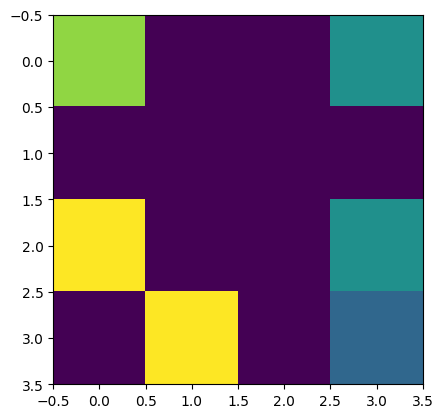

In [6]:
env = GridEnvironment()
agent = RandomAgent(env)

env.render()

## Running the Environment for 10 Timesteps

The below cell runs the environment for 10 timesteps. The vizualiztions of each of the steps will be stored in the same directory of this folder. There are 11 images (1 initial state image, 10 images representing agent running each timestep).

In [7]:
env = GridEnvironment()
agent = RandomAgent(env)

env.reset()
terminated = False

c = 1
print("Timestep: {} (Initial state)".format(0))
print("Environment state displayed in file: grid_world0.png")
print("Current State: {}".format(env.state.flatten()))
env.render("grid_world0.png")

while not terminated:
  action = agent.step()
  print("========================================")
  print("Timestep: {}".format(c))
  act = ""
  if(action == 0):
    act = "Down"
  elif(action == 1):
    act = "Up"
  elif(action == 2):
    act = "Right"
  else:
    act = "Left"
  print("Action taken: {}".format(act))
  print("Environment state displayed in file: grid_world{count}.png".format(count=c))
  print("Current State: {}".format(env.state.flatten()))
  observation, reward, terminated, negative_condition_passed, total_rewards = env.step(action)
  print("State after taking action: {}".format(observation))
  print("Reward: {}".format(reward))
  path = "grid_world{count}.png".format(count=c)
  env.render(path)
  c += 1
  time.sleep(1)

Timestep: 0 (Initial state)
Environment state displayed in file: grid_world0.png
Current State: [10.  0.  0.  6.  0.  0.  0.  0. 12.  0.  0.  6.  0. 12.  0.  4.]
Timestep: 1
Action taken: Right
Environment state displayed in file: grid_world1.png
Current State: [10.  0.  0.  6.  0.  0.  0.  0. 12.  0.  0.  6.  0. 12.  0.  4.]
State after taking action: [ 0. 10.  0.  6.  0.  0.  0.  0. 12.  0.  0.  6.  0. 12.  0.  4.]
Reward: 0
Timestep: 2
Action taken: Left
Environment state displayed in file: grid_world2.png
Current State: [ 0. 10.  0.  6.  0.  0.  0.  0. 12.  0.  0.  6.  0. 12.  0.  4.]
State after taking action: [10.  0.  0.  6.  0.  0.  0.  0. 12.  0.  0.  6.  0. 12.  0.  4.]
Reward: 0
Timestep: 3
Action taken: Right
Environment state displayed in file: grid_world3.png
Current State: [10.  0.  0.  6.  0.  0.  0.  0. 12.  0.  0.  6.  0. 12.  0.  4.]
State after taking action: [ 0. 10.  0.  6.  0.  0.  0.  0. 12.  0.  0.  6.  0. 12.  0.  4.]
Reward: 0
Timestep: 4
Action taken: Left
E

# PART 2: SARSA IMPLEMENTATION

In [8]:
def SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, q_table):

  def action_select(epsilon, state):
    # Exploitation
    if(np.random.uniform() > epsilon):
      return np.argmax(q_table[state])

    # Exploration
    else:
      return np.random.randint(4)

  rewards = []
  timesteps = []
  bad_rewards = []
  epsilon_values = []
  epsilon_values.append(epsilon)

  for i in range(0, total_episodes):
    env.reset()
    terminated = False
    agent = RandomAgent(env)

    state_prev = 0
    action_prev = action_select(epsilon, 0)

    state_count = 0
    bad_reward_count = 0
    while(not terminated):
      action = agent.step(action_prev)
      observation, reward, terminated, bad_reward, total_rewards = env.step(action)
      if(not bad_reward):
        bad_reward_count += 1
      state_next = int(np.where(observation == 10)[0])
      action_next = action_select(epsilon, int(np.where(observation == 10)[0]))
      q_table[state_prev][action_prev] = q_table[state_prev][action_prev] + learning_rate * (reward + (discount_factor * q_table[state_next][action_next]) - q_table[state_prev][action_prev])
      state_prev = state_next
      action_prev = action_next
      state_count += 1
      if(terminated):
        rewards.append(total_rewards)
        timesteps.append(state_count)
        bad_rewards.append(bad_reward_count)

    epsilon = epsilon * decay_rate
    epsilon_values.append(epsilon) 

  return q_table, rewards, timesteps, bad_rewards, epsilon_values

In [9]:
def reward_plot(rewards):
  plt.plot(rewards, 'ro')
  plt.title("Reward per Episode")
  plt.xlabel("Episode")
  plt.ylabel("Reward Value")
  plt.grid()
  return plt

In [10]:
def cumulative_reward_plot(rewards):
  x = list(range(1, len(rewards) + 1))
  y = [0] * len(rewards)
  y[0] = rewards[0]
  for i in range(1, len(rewards)):
    y[i] = y[i - 1] + rewards[i]
  plt.plot(y)
  plt.xlabel('Episode')
  plt.ylabel('Cumulative Rewards')
  plt.title('Cumulative Reward per Episode')
  plt.grid()
  return plt

In [11]:
def epsilon_decay_plot(epsilon_values):
  plt.plot(epsilon_values)
  plt.xlabel('Episode')
  plt.ylabel('Epsilon Values')
  plt.title('Epsilon Decay')
  plt.grid()
  return plt

In [12]:
def timestep_episode_plot(timestep_values):
  x = list(range(1, len(timestep_values) + 1))
  y = timestep_values
  plt.plot(timestep_values)
  plt.xlabel('Episode')
  plt.ylabel('Number of Timesteps')
  plt.title('Timesteps per Episode')
  plt.grid()
  return plt

In [13]:
def negative_rewards_episode_plot(negative_rewards):
  x = list(range(1, len(negative_rewards) + 1))
  y = negative_rewards
  plt.plot(negative_rewards)
  plt.xlabel('Episode')
  plt.ylabel('Number of Negative Rewards')
  plt.title('Negative Rewards per Episode')
  plt.grid()
  return plt

In [14]:
total_episodes = 112
timesteps_per_episode = 63
learning_rate = 0.1177497828390281
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9089726978502273
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

## Training Vizualizations

### Plot 1: Epsilon-Decay Plot

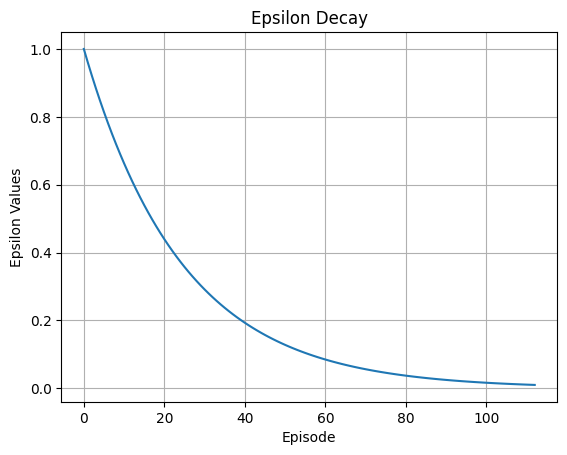

In [15]:
epsilon_decay = epsilon_decay_plot(sarsa_output[4])
epsilon_decay.show()

### Plot 2: Total Reward vs. Episode

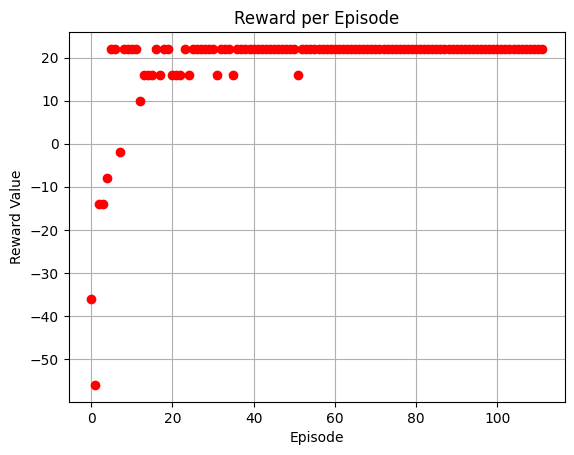

In [16]:
rewards_vs_episode = reward_plot(sarsa_output[1])
rewards_vs_episode.show()

### Plot 3: Cumulative Rewards vs. Episode

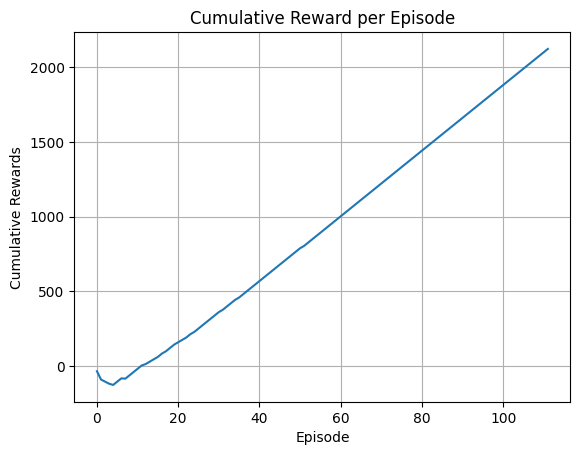

In [17]:
cumulative_rewards_vs_episode = cumulative_reward_plot(sarsa_output[1])
cumulative_rewards_vs_episode.show()

### Plot 4: Timesteps vs. Episodes

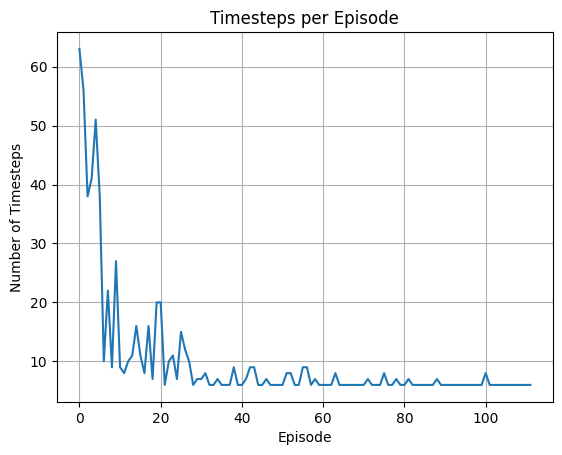

In [18]:
timesteps_vs_episode = timestep_episode_plot(sarsa_output[2])
timesteps_vs_episode.show()

### Plot 5: Number of Negative Rewards vs. Episodes

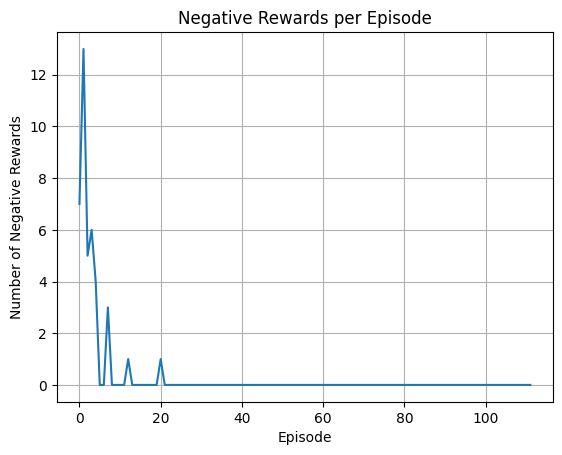

In [19]:
negative_rewards = negative_rewards_episode_plot(sarsa_output[3])
negative_rewards.show()

## Validation

In [20]:
def algo_validator(env, q_table):

  def greedy_select(state):
    return np.argmax(q_table[state])

  rewards = []

  for i in range(10):
    env.reset()
    terminated = False
    agent = RandomAgent(env)
    current_state = 0
    best_action = greedy_select(current_state)
    while(not terminated):
      action = agent.step(best_action)
      observation, reward, terminated, _, total_rewards = env.step(action)
      best_action = greedy_select(int(np.where(observation == 10)[0]))
      if(terminated):
        rewards.append(total_rewards)

  return rewards

In [21]:
env = GridEnvironment(max_timesteps=58)
decay_rate = pow((0.01 / 1), (1 / 105))
Q_table = np.zeros((env.observation_space.n, env.action_space.n))
optimal_q_values = SARSA(env, 105, 0.10427982306776293, 1, 0.9643731499897495, decay_rate, Q_table)[0]
validation_rewards = algo_validator(env, optimal_q_values)

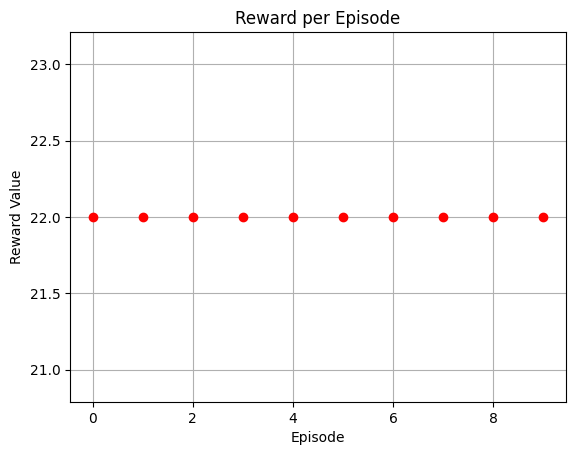

In [22]:
rewards_vs_episode = reward_plot(validation_rewards)
rewards_vs_episode.show()

## Hyper Parameter Tuning

### Parameter 1: Number of Episodes

#### Parameter 1, Setup 1: 10 Episodes

In [23]:
total_episodes = 10
timesteps_per_episode = 50
learning_rate = 0.1
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.5
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output_11 = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

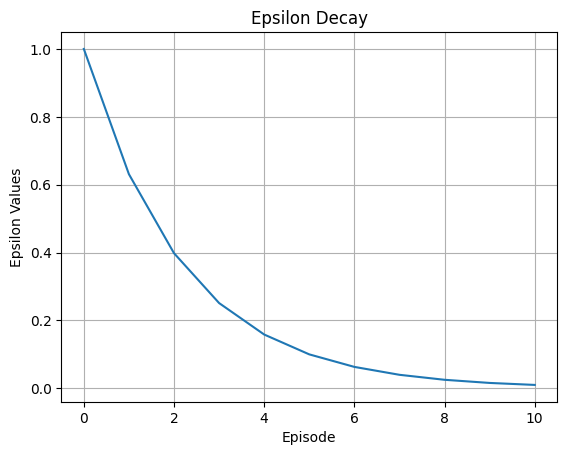

In [24]:
epsilon_decay = epsilon_decay_plot(sarsa_output_11[4])
epsilon_decay.show()

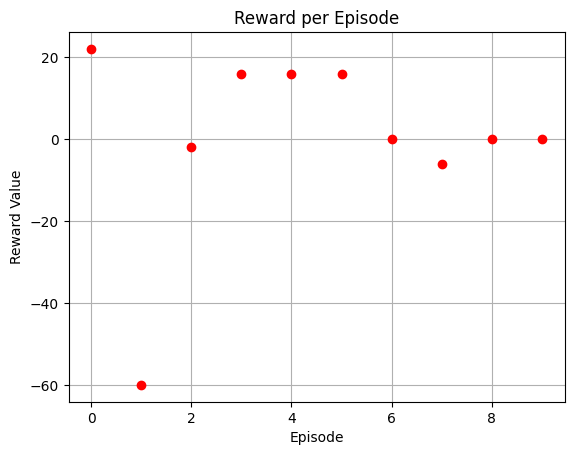

In [25]:
rewards_vs_episode = reward_plot(sarsa_output_11[1])
rewards_vs_episode.show()

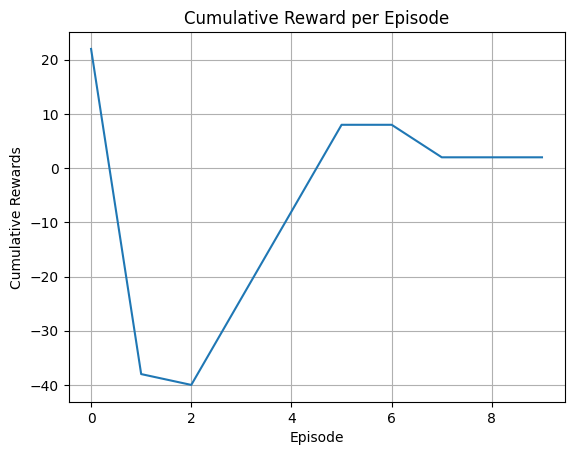

In [26]:
cumulative_rewards_vs_episode = cumulative_reward_plot(sarsa_output_11[1])
cumulative_rewards_vs_episode.show()

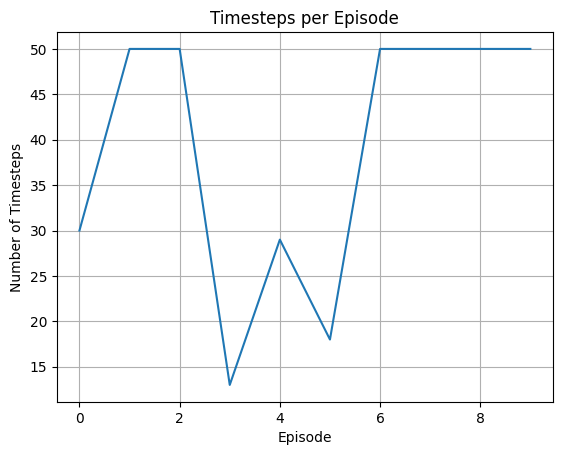

In [27]:
timesteps_vs_episode = timestep_episode_plot(sarsa_output_11[2])
timesteps_vs_episode.show()

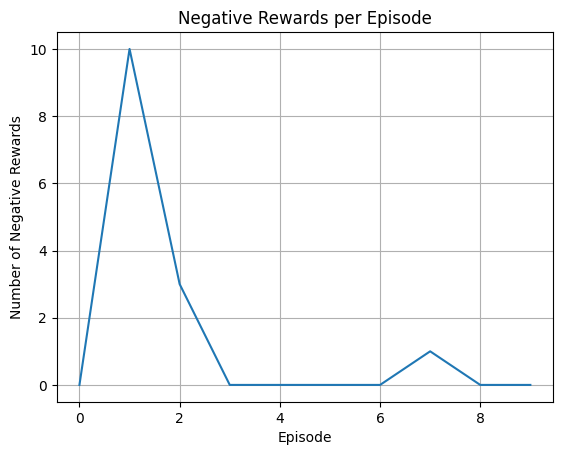

In [28]:
negative_rewards = negative_rewards_episode_plot(sarsa_output_11[3])
negative_rewards.show()

#### Parameter 1, Setup 2: 15 Episodes

In [29]:
total_episodes = 15
timesteps_per_episode = 50
learning_rate = 0.1
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.5
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output_12 = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

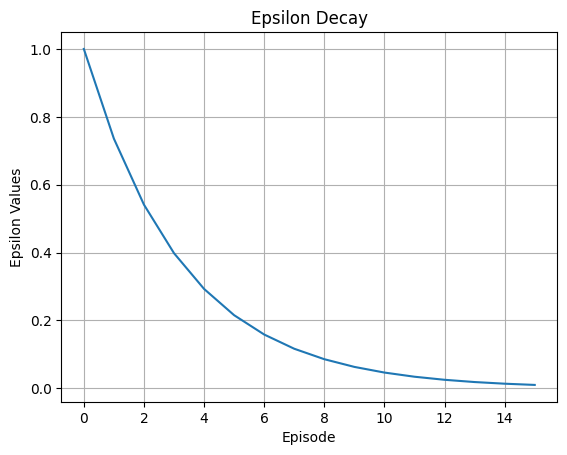

In [30]:
epsilon_decay = epsilon_decay_plot(sarsa_output_12[4])
epsilon_decay.show()

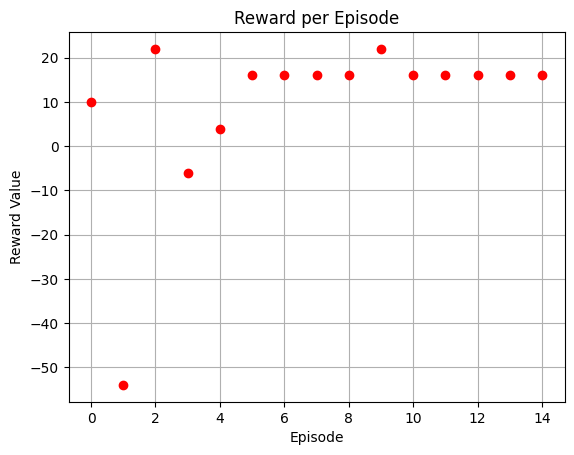

In [31]:
rewards_vs_episode = reward_plot(sarsa_output_12[1])
rewards_vs_episode.show()

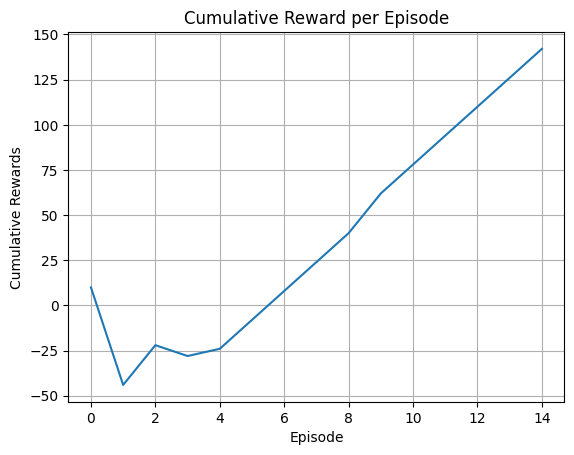

In [32]:
cumulative_rewards_vs_episode = cumulative_reward_plot(sarsa_output_12[1])
cumulative_rewards_vs_episode.show()

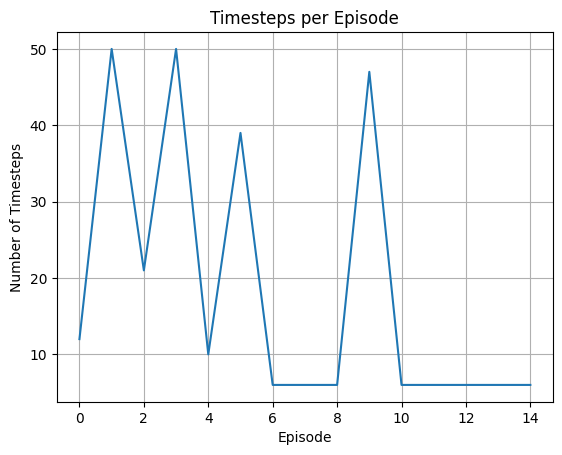

In [33]:
timesteps_vs_episode = timestep_episode_plot(sarsa_output_12[2])
timesteps_vs_episode.show()

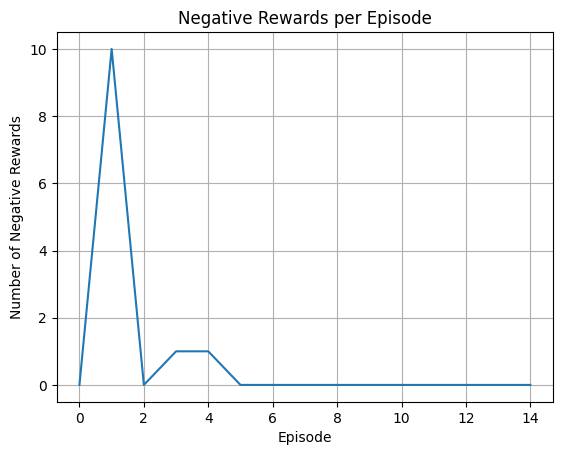

In [34]:
negative_rewards = negative_rewards_episode_plot(sarsa_output_12[3])
negative_rewards.show()

#### Parameter 1, Setup 3: 50 Episodes

In [35]:
total_episodes = 50
timesteps_per_episode = 50
learning_rate = 0.1
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.5
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output_13 = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

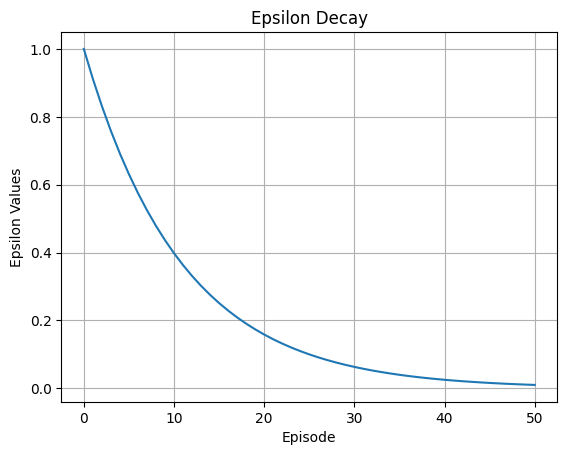

In [36]:
epsilon_decay = epsilon_decay_plot(sarsa_output_13[4])
epsilon_decay.show()

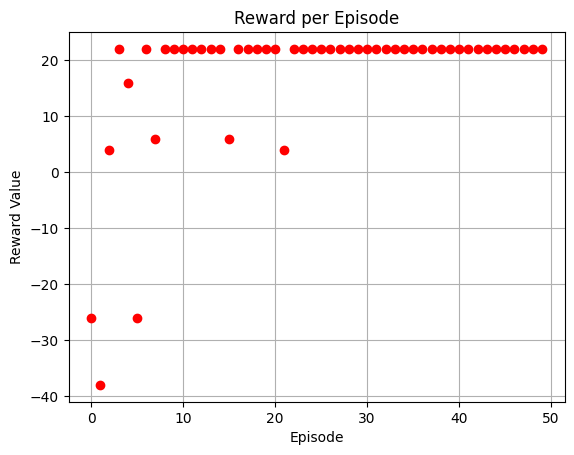

In [37]:
rewards_vs_episode = reward_plot(sarsa_output_13[1])
rewards_vs_episode.show()

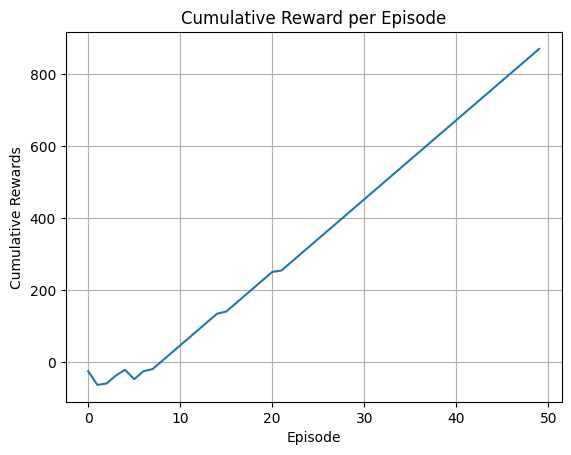

In [38]:
cumulative_rewards_vs_episode = cumulative_reward_plot(sarsa_output_13[1])
cumulative_rewards_vs_episode.show()

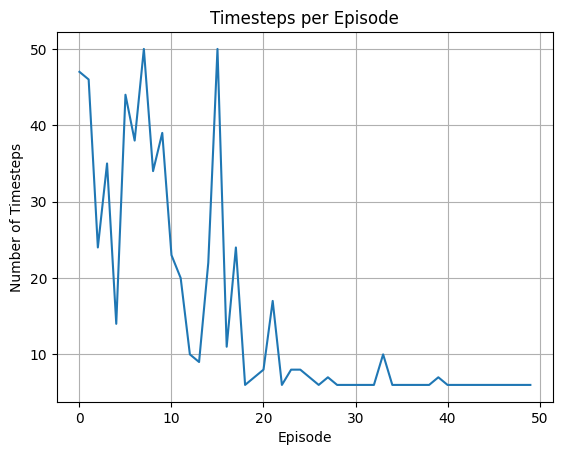

In [39]:
timesteps_vs_episode = timestep_episode_plot(sarsa_output_13[2])
timesteps_vs_episode.show()

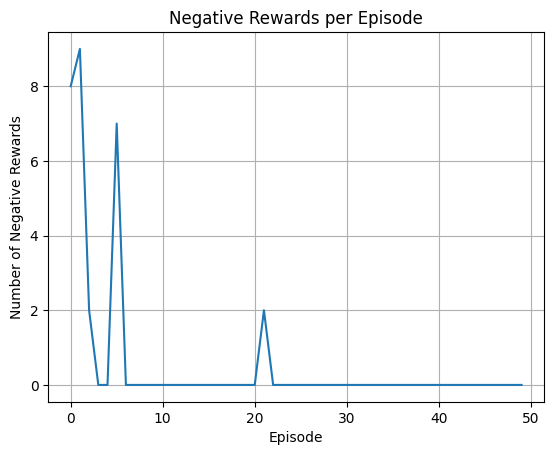

In [40]:
negative_rewards = negative_rewards_episode_plot(sarsa_output_13[3])
negative_rewards.show()

### Parameter 2: Timesteps per Episode

#### Parameter 2, Setup 1: 10 Timesteps per Episode

In [41]:
total_episodes = 200
timesteps_per_episode = 10
learning_rate = 0.1
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output_21 = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

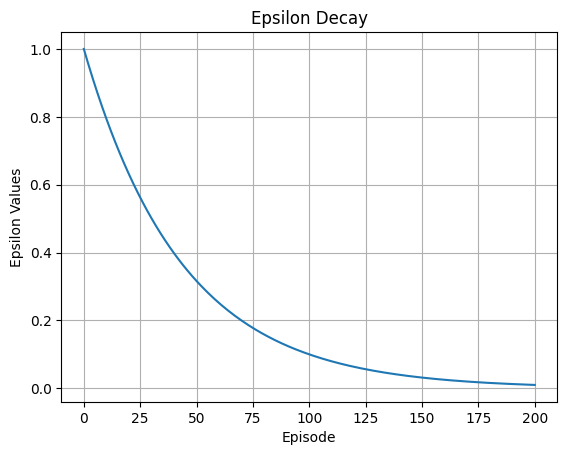

In [42]:
epsilon_decay = epsilon_decay_plot(sarsa_output_21[4])
epsilon_decay.show()

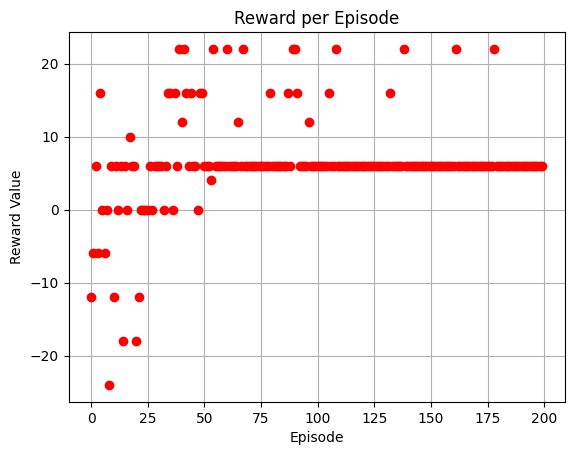

In [43]:
rewards_vs_episode = reward_plot(sarsa_output_21[1])
rewards_vs_episode.show()

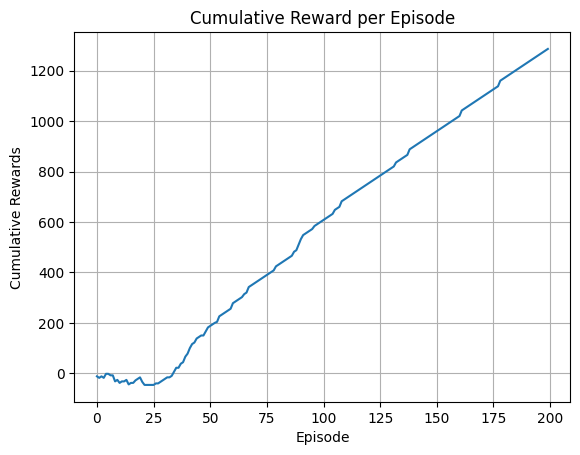

In [44]:
cumulative_rewards_vs_episode = cumulative_reward_plot(sarsa_output_21[1])
cumulative_rewards_vs_episode.show()

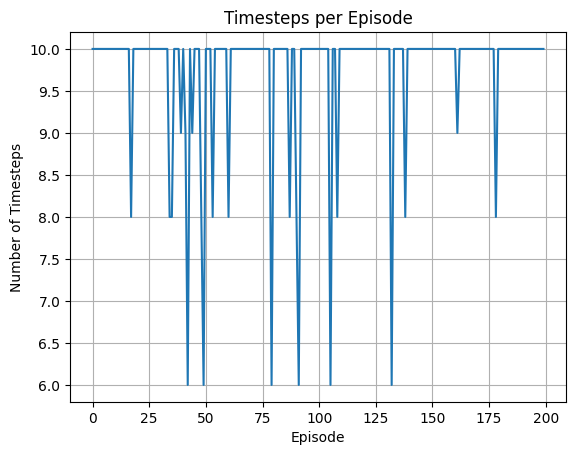

In [45]:
timesteps_vs_episode = timestep_episode_plot(sarsa_output_21[2])
timesteps_vs_episode.show()

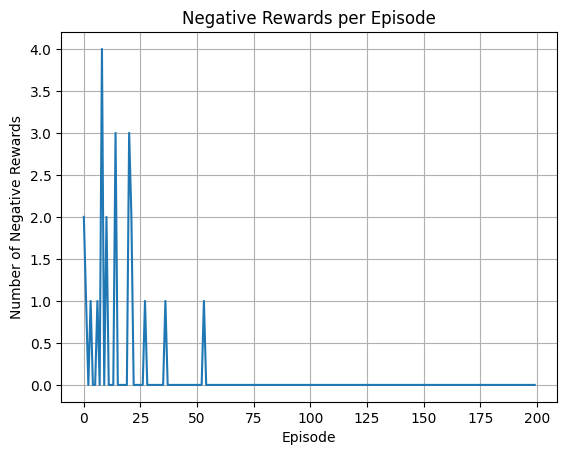

In [46]:
negative_rewards = negative_rewards_episode_plot(sarsa_output_21[3])
negative_rewards.show()

#### Parameter 2, Setup 2: 15 Timesteps per Episode



In [47]:
total_episodes = 200
timesteps_per_episode = 15
learning_rate = 0.1
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.6
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output_22 = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

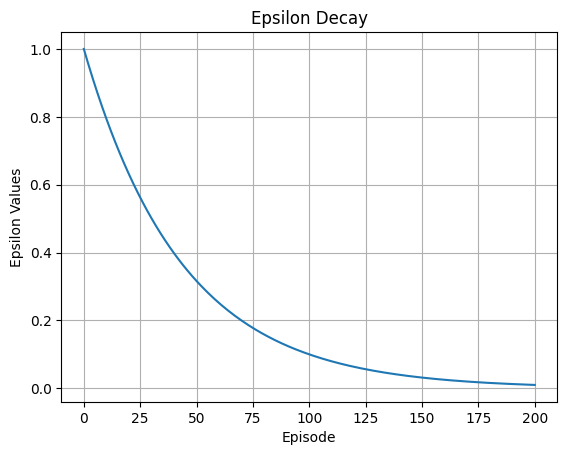

In [48]:
epsilon_decay = epsilon_decay_plot(sarsa_output_22[4])
epsilon_decay.show()

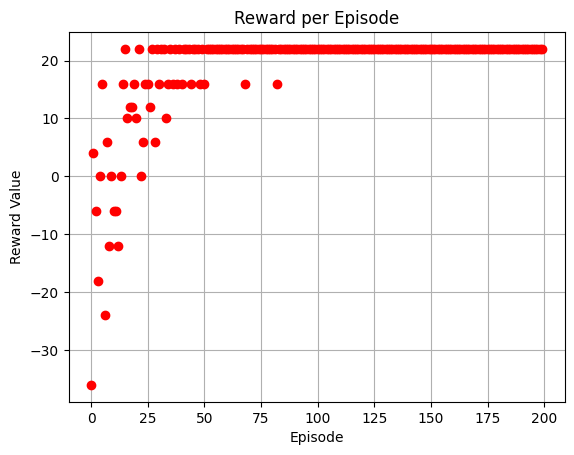

In [49]:
rewards_vs_episode = reward_plot(sarsa_output_22[1])
rewards_vs_episode.show()

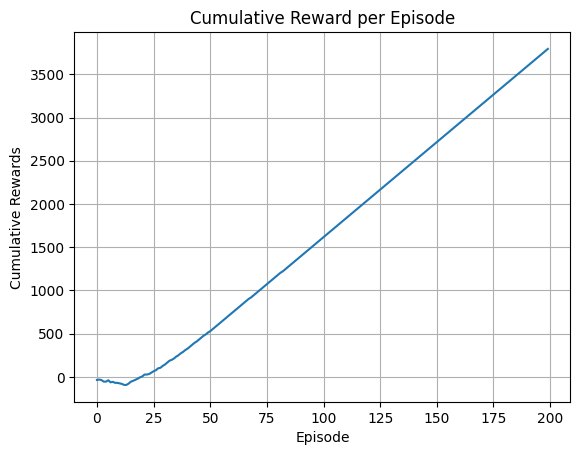

In [50]:
cumulative_rewards_vs_episode = cumulative_reward_plot(sarsa_output_22[1])
cumulative_rewards_vs_episode.show()

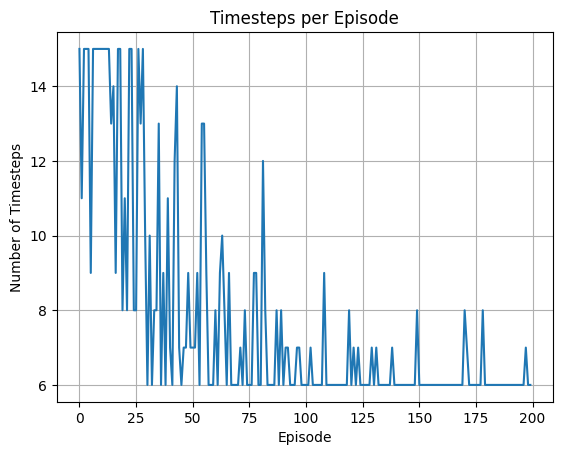

In [51]:
timesteps_vs_episode = timestep_episode_plot(sarsa_output_22[2])
timesteps_vs_episode.show()

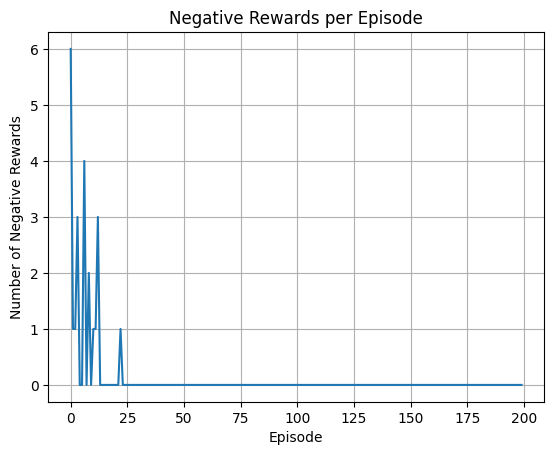

In [52]:
negative_rewards = negative_rewards_episode_plot(sarsa_output_22[3])
negative_rewards.show()

#### Parameter 2, Setup 3: 50 Timesteps per Episode

In [53]:
total_episodes = 200
timesteps_per_episode = 50
learning_rate = 0.1
epsilon = 1
epsilon_min = 0.01
discount_factor = 0.9
decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

# Initialize environment
env = GridEnvironment(max_timesteps=timesteps_per_episode)

# Initialize Q Table
Q_table = np.zeros((env.observation_space.n, env.action_space.n))

# Apply SARSA
sarsa_output_23 = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)

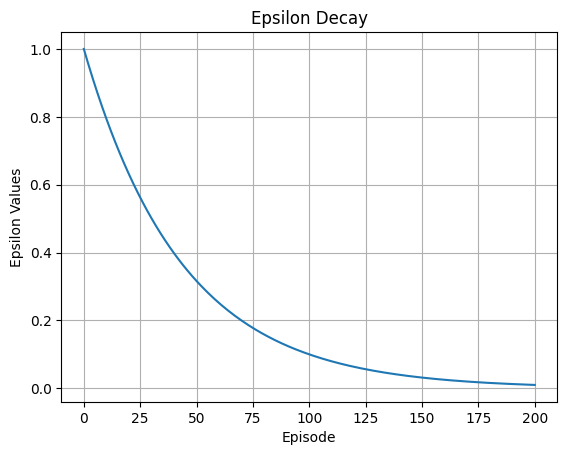

In [54]:
epsilon_decay = epsilon_decay_plot(sarsa_output_23[4])
epsilon_decay.show()

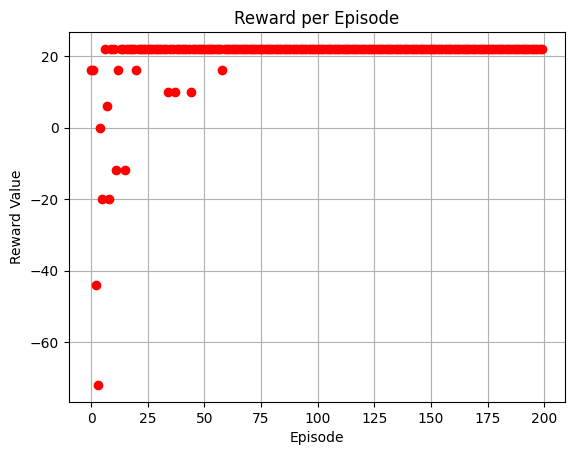

In [55]:
rewards_vs_episode = reward_plot(sarsa_output_23[1])
rewards_vs_episode.show()

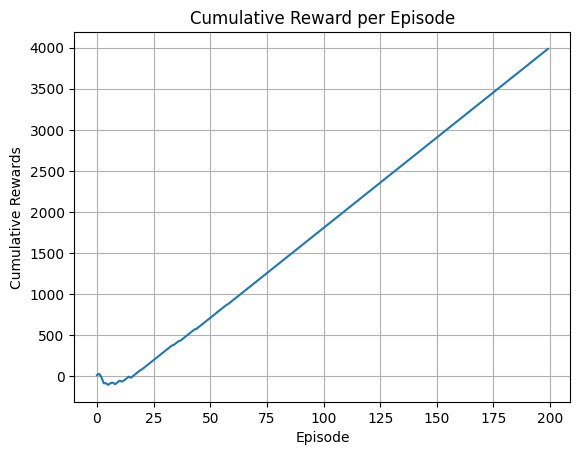

In [56]:
cumulative_rewards_vs_episode = cumulative_reward_plot(sarsa_output_23[1])
cumulative_rewards_vs_episode.show()

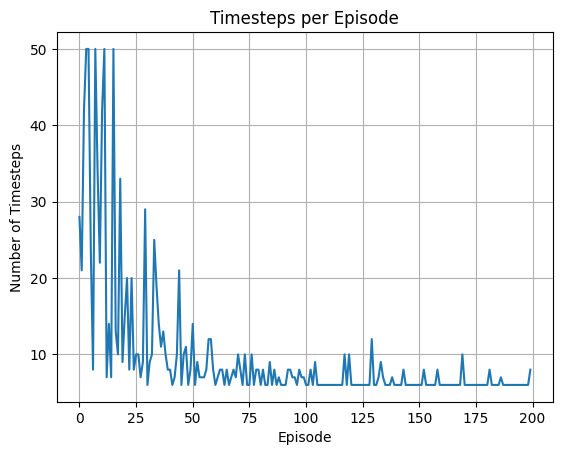

In [57]:
timesteps_vs_episode = timestep_episode_plot(sarsa_output_23[2])
timesteps_vs_episode.show()

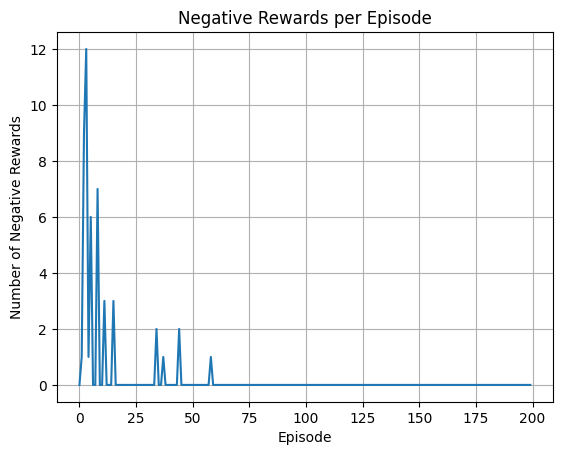

In [58]:
negative_rewards = negative_rewards_episode_plot(sarsa_output_23[3])
negative_rewards.show()

## Using Optuna to Get Best Hyper Parameters

In [59]:
def objective(trial):
  total_episodes = trial.suggest_int(name="total_episodes", low=20, high=1000)
  timesteps_per_episode = trial.suggest_int(name="timesteps_per_episode", low=25, high=100)
  learning_rate = trial.suggest_float(name="learning_rate", low=0.1, high=0.2)
  epsilon = 1
  epsilon_min = 0.01
  discount_factor = trial.suggest_float(name="discount_factor", low=0.9, high=0.99)
  decay_rate = pow((epsilon_min / epsilon), (1 / total_episodes))

  env = GridEnvironment(max_timesteps=timesteps_per_episode)
  Q_table = np.zeros((env.observation_space.n, env.action_space.n))
  sarsa_output = SARSA(env, total_episodes, learning_rate, epsilon, discount_factor, decay_rate, Q_table)
  return sum(sarsa_output[1]) / len(sarsa_output[1])

In [60]:
study = optuna.create_study(study_name="sarsa_tuning", direction="maximize")
study.optimize(objective, n_trials=300)

[I 2023-05-11 23:19:18,863] A new study created in memory with name: sarsa_tuning
[I 2023-05-11 23:19:20,385] Trial 0 finished with value: 17.67935871743487 and parameters: {'total_episodes': 998, 'timesteps_per_episode': 46, 'learning_rate': 0.1618994769299254, 'discount_factor': 0.9639280201929855}. Best is trial 0 with value: 17.67935871743487.
[I 2023-05-11 23:19:21,978] Trial 1 finished with value: 14.43574297188755 and parameters: {'total_episodes': 996, 'timesteps_per_episode': 25, 'learning_rate': 0.17308571005186524, 'discount_factor': 0.9628274888115396}. Best is trial 0 with value: 17.67935871743487.
[I 2023-05-11 23:19:22,859] Trial 2 finished with value: 19.97724399494311 and parameters: {'total_episodes': 791, 'timesteps_per_episode': 67, 'learning_rate': 0.16171289110926934, 'discount_factor': 0.9139701300869152}. Best is trial 2 with value: 19.97724399494311.
[I 2023-05-11 23:19:23,103] Trial 3 finished with value: 19.94736842105263 and parameters: {'total_episodes': 34

In [61]:
study.best_params

{'total_episodes': 478,
 'timesteps_per_episode': 96,
 'learning_rate': 0.14239220223820115,
 'discount_factor': 0.9079414148975035}